In [2]:
import torch
import torchvision
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, models, transforms
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import PCA

In [3]:
class AutoEncoder(nn.Module):
    def __init__(self, **kwargs):
        super().__init__()
        self.input_shape = kwargs["input_shape"]
        # number of hidden units in first hidden layer
        self.n_units = kwargs["n_units"]
        self.half_units = kwargs["n_units"] // 2
        
        self.encoder = torch.nn.Sequential(
            # Linear(): Initiate a linear function theta*x + b
            nn.Linear(in_features=self.input_shape, out_features=self.n_units),
            torch.nn.ReLU(),
            nn.Linear(in_features=self.n_units, out_features=self.half_units),
            # torch.nn.ReLU(),
            # nn.Linear(in_features=64, out_features=32),
        )
        self.decoder = torch.nn.Sequential(
            # nn.Linear(in_features=32, out_features=64),
            # torch.nn.ReLU(),
            nn.Linear(in_features=self.half_units, out_features=self.n_units),
            torch.nn.ReLU(),
            nn.Linear(in_features=self.n_units, out_features=self.input_shape),
            torch.nn.Sigmoid()
        )
    
    # x denotes features
    def forward(self, X):
        encode = self.encoder(X)
        decode = self.decoder(encode)
        return decode

In [165]:
data = np.ndarray(shape=(10000,30,30))
n_features = data.shape[1] * data.shape[2]

for i in range(10000):
    path = f'data/jet_matrices/sample{i+1}.dat'
    sample = np.loadtxt(path, unpack = True)
    data[i] = sample

In [167]:
# Flatten data and convert to Torch Tensor

# 10,000 samples, 900 features
X = np.ndarray(shape=(10000, n_features))
for i, sample in enumerate(data):
    flat = sample.flatten()
    X[i] = flat
    #print(X[i])

X = torch.from_numpy(X)
# Convert all scalars to floats. May affect training behavior (ie. reconstructions made of non-binary scalar values)
X = X.float()
print(X)

tensor([[1., 1., 1.,  ..., 0., 0., 0.],
        [1., 1., 1.,  ..., 0., 0., 0.],
        [1., 1., 1.,  ..., 0., 0., 0.],
        ...,
        [1., 1., 1.,  ..., 0., 0., 0.],
        [1., 1., 1.,  ..., 0., 0., 0.],
        [1., 1., 1.,  ..., 0., 0., 0.]])


[0.4563787  0.58873093 0.65312755 0.7048038  0.74008924 0.76756316
 0.7884263  0.80585605 0.82011926 0.8316467  0.84206367 0.85014373
 0.85787964 0.8645117  0.87028015 0.87538475 0.8797506  0.8838839
 0.88795614 0.891918   0.8953373  0.8986876  0.90189934 0.9050165
 0.90797085 0.91083103 0.9136078  0.91616505 0.91856223 0.92073613
 0.92289317 0.9249155  0.926796   0.9286278  0.9304067  0.93217474
 0.9338542  0.9354077  0.9369447  0.9384149  0.939854   0.9412729
 0.9426667  0.94403005 0.9453404  0.94663715 0.9478411  0.9489902
 0.9501023 ]


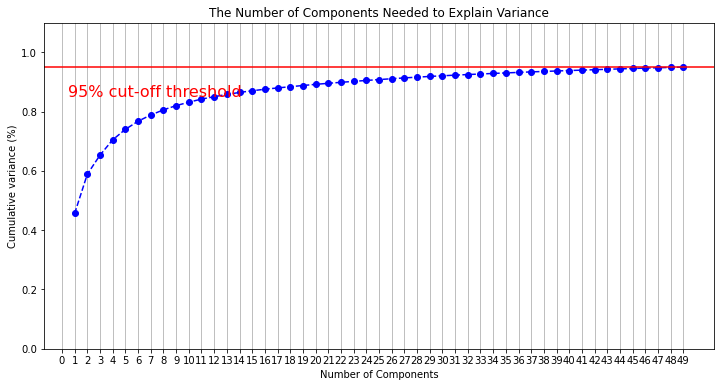

In [75]:
# Plot cumulative explained variance w.r.t. number of components

pca = PCA(n_components=0.95).fit(X.numpy())

#% matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (12,6)

fig, ax = plt.subplots()
y = np.cumsum(pca.explained_variance_ratio_)
print(y)
# n_components = number of components needed to reach cum. variance threshold
n_components = y.size
xi = np.arange(1, n_components+1, step=1)

plt.ylim(0.0,1.1)
plt.plot(xi, y, marker='o', linestyle='--', color='b')

plt.xlabel('Number of Components')
plt.xticks(np.arange(0, n_components+1, step=1)) #change from 0-based array index to 1-based human-readable label
plt.ylabel('Cumulative variance (%)')
plt.title('The Number of Components Needed to Explain Variance')

plt.axhline(y=0.95, color='r', linestyle='-')
plt.text(0.5, 0.85, '95% cut-off threshold', color = 'red', fontsize=16)

ax.grid(axis='x')
plt.show()

Text(0.5, 1.0, 'Significance Towards Variance of Each Principal Component')

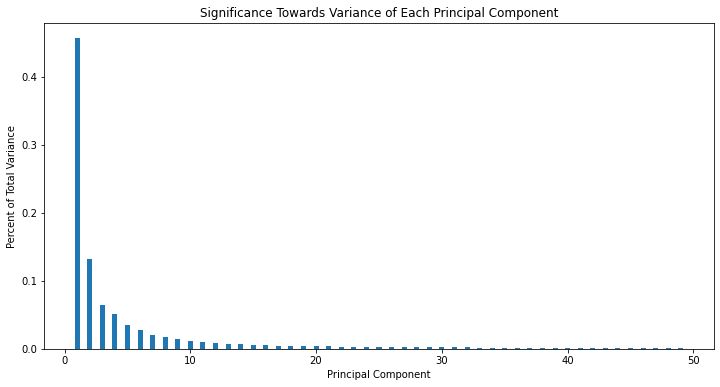

In [76]:
plt.rcParams["figure.figsize"] = (12,6)
fig, ax = plt.subplots()
plt.bar(xi, pca.explained_variance_ratio_, width=0.4)
plt.ylabel("Percent of Total Variance")
plt.xlabel("Principal Component")
plt.title("Significance Towards Variance of Each Principal Component")

In [215]:
# PCA

# Toggle to indicate to training that PCA is in use
is_pca = True
# -- DEFINE NUMBER OF COMPONENTS HERE --
n_components = 5

pca = PCA(n_components=n_components).fit(X.numpy())

print(X)
# If fails, re-run "Flatten data..." cell
X_pca = pca.fit_transform(X)
X_pca = torch.from_numpy(X_pca)
# Convert all scalars to floats. May affect training behavior (ie. reconstructions made of non-binary scalar values)
X_pca = X_pca.float()
# Replace former n_features with number of components
n_features = X_pca.shape[1]

tensor([[1., 1., 1.,  ..., 0., 0., 0.],
        [1., 1., 1.,  ..., 0., 0., 0.],
        [1., 1., 1.,  ..., 0., 0., 0.],
        ...,
        [1., 1., 1.,  ..., 0., 0., 0.],
        [1., 1., 1.,  ..., 0., 0., 0.],
        [1., 1., 1.,  ..., 0., 0., 0.]])


In [216]:
# Changes X based on whether PCA was used
if is_pca:
    X_2 = X_pca
else:
    X_2 = X

batch_size = 32
lr = 1e-3
train_size = int(0.8 * len(X_2))
test_size = len(X_2) - train_size

In [217]:
# Initate data loaders

train, test = torch.utils.data.random_split(X_2, [train_size, test_size])

train_loader = torch.utils.data.DataLoader(
    train, batch_size=batch_size, shuffle=True, num_workers=0, pin_memory=False
)

test_loader = torch.utils.data.DataLoader(
    test, batch_size=batch_size, shuffle=False, num_workers=0
)

In [ ]:
# # USE FOR MNIST ONLY

# # Use gpu if available
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# print(device)

# # Define model
# model = AutoEncoder(input_shape=n_features, n_units=32).to(device)

# # Define Adam optimizer
# optimizer = optim.Adam(model.parameters(), lr=lr)

# # Mean-squared error loss
# criterion = nn.MSELoss()

# input_shape = 784
# # Convert numpy array to tensor
# transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor()])

# # Define 
# train = torchvision.datasets.MNIST(
#     root="~/torch_datasets", train=True, transform=transform, download=True
# )

# test = torchvision.datasets.MNIST(
#     root="~/torch_datasets", train=False, transform=transform, download=True
# )

# train_loader = torch.utils.data.DataLoader(
#     train, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True
# )

# test_loader = torch.utils.data.DataLoader(
#     test, batch_size=batch_size, shuffle=False, num_workers=4
# )

In [ ]:
def CustomCrossEntropy(outputs, targets):
    pass

In [218]:
# Training

# Use gpu if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

# Define model
model = AutoEncoder(input_shape=n_features, n_units=32).to(device)

# Define Adam optimizer
optimizer = optim.Adam(model.parameters(), lr=lr)

# Mean-squared error loss
criterion = nn.MSELoss()

# Reset model state if previously trained
torch.manual_seed(1)
def weights_init(m):
    if isinstance(m, torch.nn.Linear):
        torch.nn.init.xavier_uniform_(m.weight.data)
        print("existing instance")

model.apply(weights_init)

print("Training...")

epochs=5
for epoch in range(epochs):
    loss = 0
    for i, batch in enumerate(train_loader, 0):
        
        # reshape mini-batch data from [batch_size, 30, 30] to [batch_size, 900]
        # load it to the active device
        batch = batch.view(-1, n_features).to(device)
        
        # reset the gradients back to zero
        # PyTorch accumulates gradients on subsequent backward passes
        optimizer.zero_grad()
        
        # compute reconstructions
        outputs = model(batch)
        
        # compute training reconstruction loss
        train_loss = criterion(outputs, batch)
        
        # compute accumulated gradients
        train_loss.backward()
        
        # perform parameter update based on current gradients
        optimizer.step()
        
        # add the mini-batch training loss to epoch loss
        loss += train_loss.item()
    
    # compute the epoch training loss
    loss = loss / len(train_loader)
    
    # display the epoch training loss
    print("Epoch : {}/{}, Training Loss = {:.6f}".format(epoch + 1, epochs, loss))

cuda
existing instance
existing instance
existing instance
existing instance
Training...
Epoch : 1/5, Training Loss = 3.189227
Epoch : 2/5, Training Loss = 2.894565
Epoch : 3/5, Training Loss = 2.856386
Epoch : 4/5, Training Loss = 2.854196
Epoch : 5/5, Training Loss = 2.853665


In [ ]:
# PATH = './cifar_net.pth'
# torch.save(net.state_dict(), PATH)

In [219]:
# Testing

# Decoupled into three lists due to issue with placing torch tensors into multidimensional lists
batches = []
recons = []
test_losses = []

# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    i = 1
    for batch in test_loader:
        #batch = batch[0]
        batch = batch.view(-1, n_features).to(device)
        reconstructions = model(batch)
        # Reconstruction loss
        test_loss = criterion(reconstructions, batch)
        # Store samples, predictions, and loss for visualization purposes
        batches.append(batch)
        recons.append(reconstructions)
        test_losses.append(test_loss)
        print(f'Batch {i}: {test_loss.item()}')
        i += 1

test_loss_avg = sum(test_losses) / len(test_losses)
print(f"Average Test Reconstruction Loss: {test_loss_avg}")

Batch 1: 3.061349630355835
Batch 2: 3.1301255226135254
Batch 3: 3.2794456481933594
Batch 4: 3.678225040435791
Batch 5: 2.9448394775390625
Batch 6: 2.6437416076660156
Batch 7: 2.3226916790008545
Batch 8: 3.015909433364868
Batch 9: 2.663611888885498
Batch 10: 2.603630781173706
Batch 11: 2.825430393218994
Batch 12: 2.2224199771881104
Batch 13: 3.41611647605896
Batch 14: 2.275343656539917
Batch 15: 3.048762798309326
Batch 16: 2.690869092941284
Batch 17: 3.1981170177459717
Batch 18: 2.295318603515625
Batch 19: 2.3985583782196045
Batch 20: 3.049241304397583
Batch 21: 2.959367513656616
Batch 22: 3.125251293182373
Batch 23: 2.803711414337158
Batch 24: 1.8103160858154297
Batch 25: 3.3551719188690186
Batch 26: 2.69700288772583
Batch 27: 3.148571729660034
Batch 28: 2.782015562057495
Batch 29: 3.133075475692749
Batch 30: 2.7365128993988037
Batch 31: 3.494208574295044
Batch 32: 3.951587438583374
Batch 33: 2.1428639888763428
Batch 34: 2.390960454940796
Batch 35: 3.1192965507507324
Batch 36: 2.701640

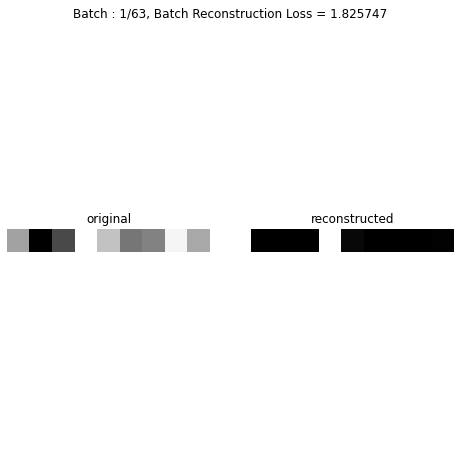

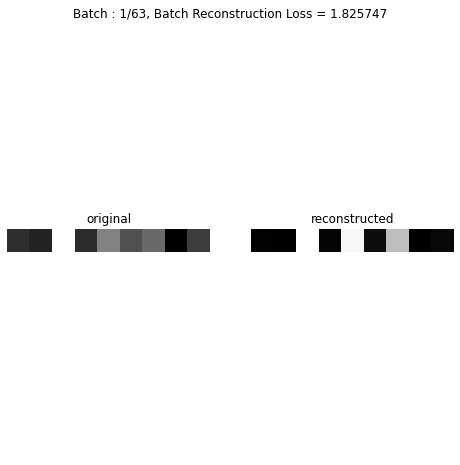

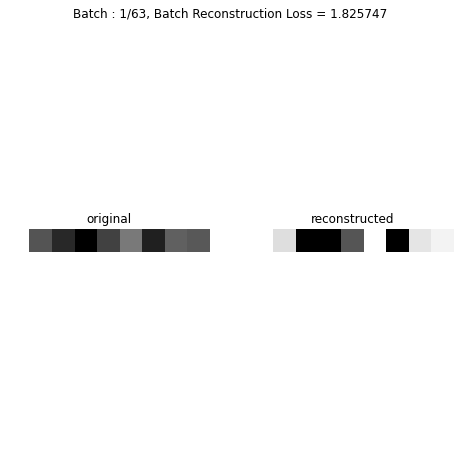

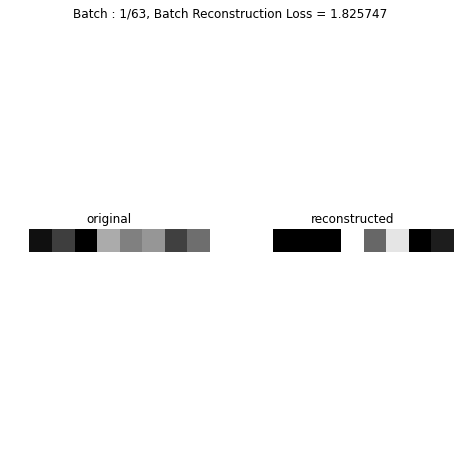

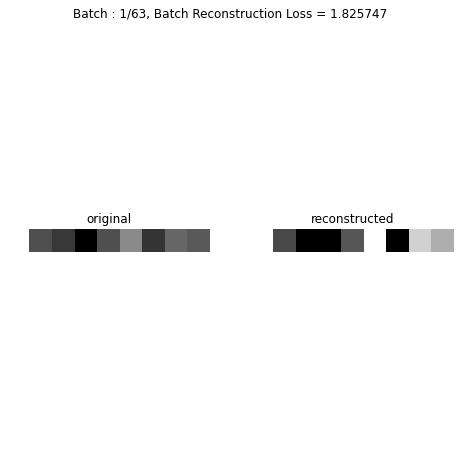

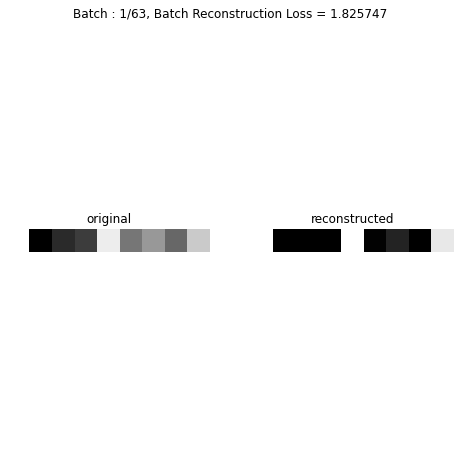

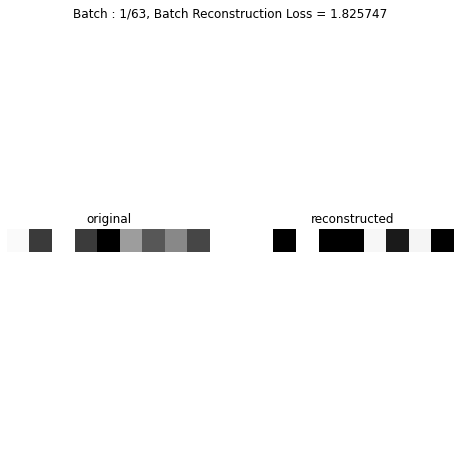

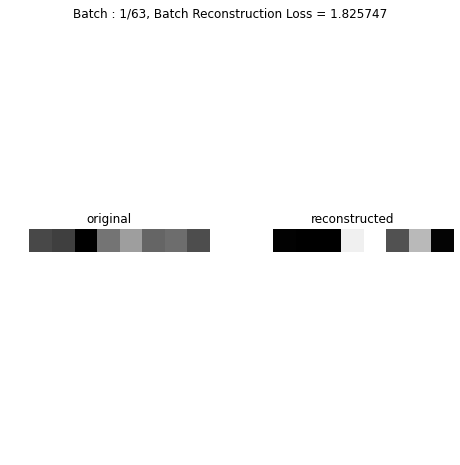

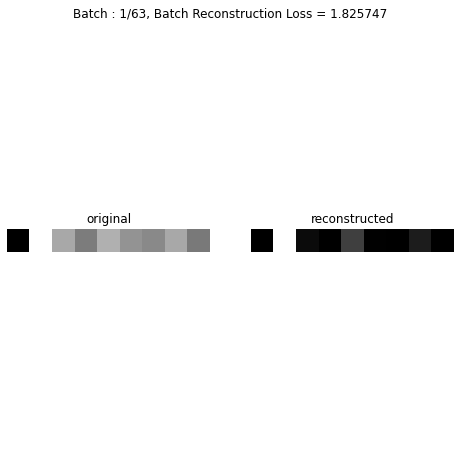

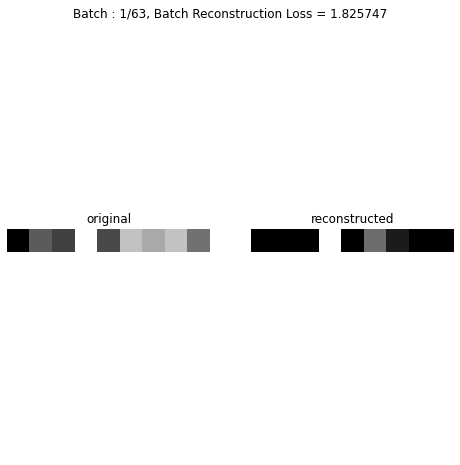

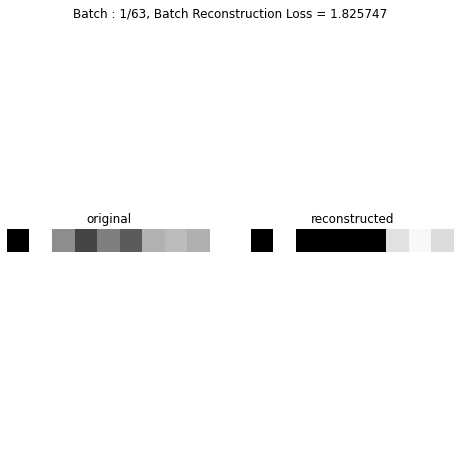

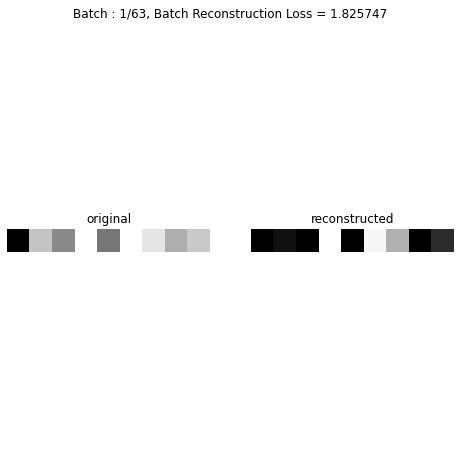

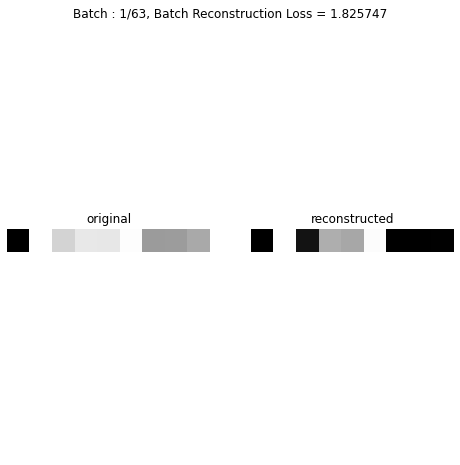

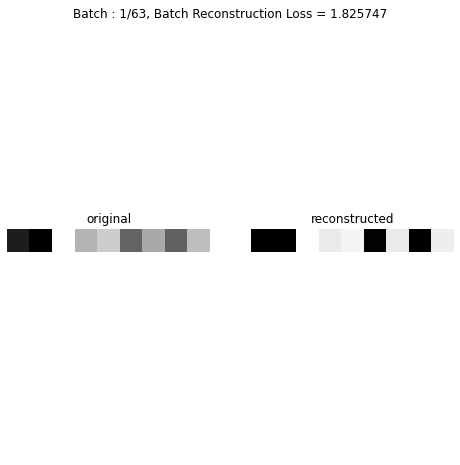

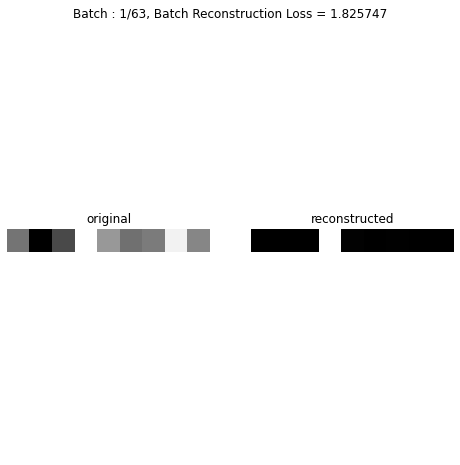

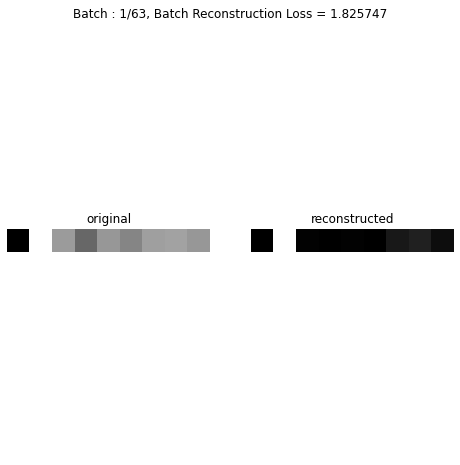

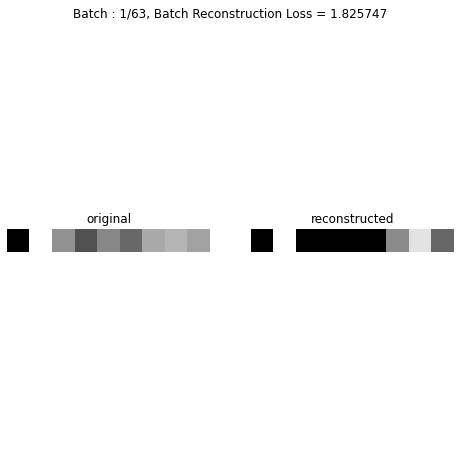

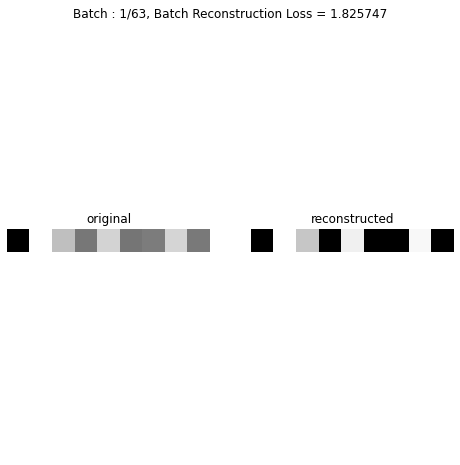

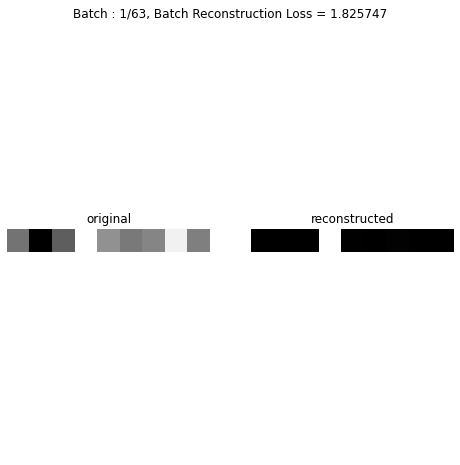

KeyboardInterrupt: 

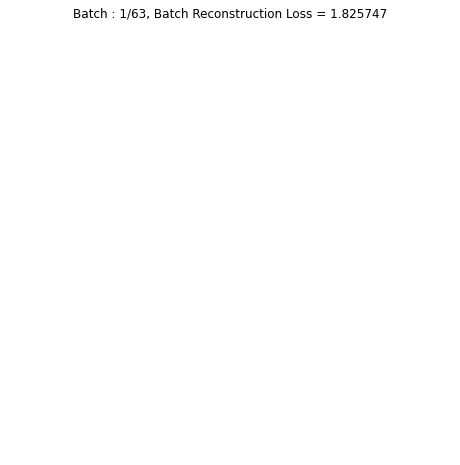

In [209]:
# Visualization

for i in range(len(recons)):
    loss = test_losses[i]
    batch = batches[i]
    reconstructions = recons[i]
    # Iterate through all examples in ith batch
    for j in range(len(batch)):
        # Reshape original example for plotting back into 30x30
        # or keep as vector of components if using PCA.
        if is_pca:
            original = batch[j].reshape(1, n_features)
        else:
            original = batch[j].reshape(data.shape[1], data.shape[2])
        original = original.cpu()
        # Reshape reconstructed example for plotting
        # or keep as vector of components if using PCA.
        if is_pca:
            reconstruction = reconstructions[j].reshape(1, n_features)
        else:
            reconstruction = reconstructions[j].reshape(data.shape[1], data.shape[2])
        reconstruction = reconstruction.cpu()
        
        fig = plt.figure(figsize=(8, 8))
        plt.title("Batch : {}/{}, Batch Reconstruction Loss = {:.6f}".format(i+1, len(recons), loss))
        plt.axis('off')
        # display original
        fig.add_subplot(1, 2, 1)
        plt.imshow(original)
        plt.axis('off')
        plt.title("original")
        plt.gray()
        
        # fig.get_xaxis().set_visible(False)
        # fig.get_yaxis().set_visible(False)

        # display reconstruction
        fig.add_subplot(1, 2, 2)
        plt.imshow(reconstruction)
        plt.axis('off')
        plt.title("reconstructed")
        plt.gray()
        # fig.get_xaxis().set_visible(False)
        # fig.get_yaxis().set_visible(False)
        plt.show()
        
        # w = 10
        # h = 10
        # fig = plt.figure(figsize=(8, 8))
        # columns = 4
        # rows = 5
        # for i in range(1, columns*rows +1):
        #     img = np.random.randint(10, size=(h,w))
        #     fig.add_subplot(rows, columns, i)
        #     plt.imshow(img)
        # plt.show()